In [1]:
# 单层 LSTM 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

In [3]:
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

In [4]:
# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
# dataset = dataset.drop(['date'], axis=1)
dataset = dataset.fillna(0)

In [5]:
# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
TRAIN_VALIDATION_RATIO = 0.9
TRAIN_BATCH_SIZE = 40                                                        # 注意：BATCH_SIZE是要能够整除(total_seq_count-1)的
TEST_BATCH_SIZE = 1
SEQ_LENGTH = 25
Y_SEQ_LEN = 1                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
Y_DIM = 1
X_DIM = dataset.shape[1]-Y_SEQ_LEN                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)                   # 数据一共是 seq_count x seq_len x (x_in_dim+Y_SEQ_LEN) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))

# TEST_BATCH_COUNT  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
TEST_BATCH_SIZE  = (rolling_data.shape[0])%TRAIN_BATCH_SIZE
if TEST_BATCH_SIZE == 0:                                                                   # 如果 rolling_data 刚好被整除，那就专门留一整块给test，全部算一个batch
    TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_COUNT = 1
TRAIN_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) * TRAIN_VALIDATION_RATIO)
VALID_BATCH_COUNT = int(((rolling_data.shape[0]-TEST_BATCH_SIZE*TEST_BATCH_COUNT)//TRAIN_BATCH_SIZE) - TRAIN_BATCH_COUNT)

print("TRAIN_BATCH_COUNT : {}".format(TRAIN_BATCH_COUNT))
print("VALID_BATCH_COUNT : {}".format(VALID_BATCH_COUNT))
print("TEST_BATCH_COUNT  : {}".format(TEST_BATCH_COUNT))

# train = rolling_data[:-test_seq_count].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 tain_batch_count x BATCH_SIZE x seq_len x in_dim 格式
# test  = rolling_data[-test_seq_count:].reshape(-1, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_SEQ_LEN)           # 把数据转成 test_batch_count x BATCH_SIZE x seq_len x in_dim 格式

train = rolling_data[:TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE].reshape(TRAIN_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
valid = rolling_data[TRAIN_BATCH_COUNT*TRAIN_BATCH_SIZE:-TEST_BATCH_COUNT*TEST_BATCH_SIZE].reshape(VALID_BATCH_COUNT, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)     # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-TEST_BATCH_COUNT*TEST_BATCH_SIZE:].reshape(TEST_BATCH_COUNT, TEST_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

TRAIN_BATCH_COUNT = train.shape[0]
TRAIN_BATCH_SIZE = train.shape[1]
VALID_BATCH_COUNT = valid.shape[0]
VALID_BATCH_SIZE = valid.shape[1]
TEST_BATCH_COUNT = test.shape[0]
TEST_BATCH_SIZE = test.shape[1]

train = torch.tensor(train)
valid = torch.tensor(valid)
test  = torch.tensor(test)


train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
valid_x, valid_y = valid[:,:,:,Y_SEQ_LEN:], valid[:,:,-1:,0:Y_SEQ_LEN]           # [valid_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
valid_y = valid_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y_seq_len]  to [train_batch_count, batch_size, y_seq_len, 1-dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y_seq_len]  to  [test_batch_count, batch_size, y_seq_len, 1-dim]


train_x = train_x.to(device)
train_y = train_y.to(device)
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("valid_x: {}".format(valid_x.shape))
print("valid_y: {}".format(valid_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train.shape[0]))
print("valid_batch_count: {}".format(valid.shape[0]))
print("test_batch_count:  {}".format(test.shape[0]))

rolling_data shape: (1260, 25, 136)
seq count: 1260
seq length: 25
TRAIN_BATCH_COUNT : 27
VALID_BATCH_COUNT : 4
TEST_BATCH_COUNT  : 1
train_x: torch.Size([27, 40, 25, 135])
train_y: torch.Size([27, 40, 1, 1])
valid_x: torch.Size([4, 40, 25, 135])
valid_y: torch.Size([4, 40, 1, 1])
test_x:  torch.Size([1, 20, 25, 135])
test_y:  torch.Size([1, 20, 1, 1])
train_batch_count: 27
valid_batch_count: 4
test_batch_count:  1


In [6]:
# 定义 LSTM 模型


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_dim_size, num_layers, output_size, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_dim_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim_size, output_size)

        # self.h0 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_dim_size).float().to(device)
        # self.c0 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_dim_size).float().to(device)
        
        self.init_weights3()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights2(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
    
    def init_weights3(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x, hidden, cell):
        x = x.float()

        # x = self.dropout(x)
        
        lstm_out, (h_n, c_n) = self.lstm(x, (hidden, cell))
        
        # lstm_out = self.dropout(lstm_out)

        predictions = self.linear_2(lstm_out)
        
        return predictions, h_n, c_n


In [7]:
# 训练 LSTM 模型 ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异

HIDDEN_SIZE = 1024
NUM_LAYERS = 2

# RMSE — 均方根误差
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

#MAPE——平均绝对百分比误差  mean_absolute_percent_error
def MAPE(y_pred ,y_true):
    absolute_percent_error = (torch.abs(y_pred-y_true)+1e-7)/(torch.abs(y_true)+1e-7)
    return torch.mean(absolute_percent_error)

model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).float().to(device)
LR = 1e-6
loss_func = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)

9 of 2000 epoch 	 train_loss: 7.610 	 train_MAPE: 96.47% 	 train_r2: -1871.219 	 valid_loss: 6.828 	 valid_MAPE: 96.00% 	 valid_r2: -8040.550
19 of 2000 epoch 	 train_loss: 5.562 	 train_MAPE: 70.48% 	 train_r2: -973.713 	 valid_loss: 4.317 	 valid_MAPE: 60.64% 	 valid_r2: -3065.356
29 of 2000 epoch 	 train_loss: 0.418 	 train_MAPE: 4.64% 	 train_r2: -5.455 	 valid_loss: 0.647 	 valid_MAPE: 8.84% 	 valid_r2: -85.805
39 of 2000 epoch 	 train_loss: 0.381 	 train_MAPE: 4.27% 	 train_r2: -4.259 	 valid_loss: 0.639 	 valid_MAPE: 8.76% 	 valid_r2: -79.829
49 of 2000 epoch 	 train_loss: 0.357 	 train_MAPE: 4.00% 	 train_r2: -3.657 	 valid_loss: 0.627 	 valid_MAPE: 8.65% 	 valid_r2: -74.129
59 of 2000 epoch 	 train_loss: 0.340 	 train_MAPE: 3.83% 	 train_r2: -3.356 	 valid_loss: 0.611 	 valid_MAPE: 8.45% 	 valid_r2: -68.212
69 of 2000 epoch 	 train_loss: 0.327 	 train_MAPE: 3.68% 	 train_r2: -3.121 	 valid_loss: 0.599 	 valid_MAPE: 8.30% 	 valid_r2: -63.817
79 of 2000 epoch 	 train_loss: 0.317

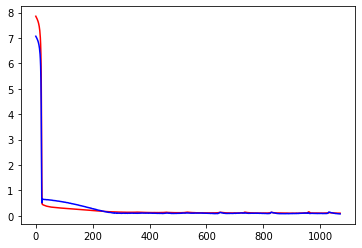

min train loss: 0.106
min valid loss: 0.078


In [8]:
def ACC(y_hat, y_real):
    y_real = np.array(y_real) + 1
    y_hat = np.array(y_hat) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((y_real - y_hat) / y_real)))
    return percentage * 100

# 定义 RMSE 损失函数。因为torch没有。
def RMSE(y_hat, y):
    return torch.sqrt(torch.mean((y_hat-y)**2))


# 定义 MAPE 计算函数。平均绝对百分比误差：不受量纲影响。但y接近0时受极端值影响。为（0%）表示完美模型，MAPE 大于 （100%）则表示劣质模型。
def MAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y)+1e-7)
    return torch.mean(absolute_percent_error)

# 定义了 R2 的计算函数。决定系数：反映因变量的全部变异能通过回归关系被自变量解释的比例。
# R2<=1，R2为1时说明预测模型不犯任何错误；R2为0时说明预测模型等于基准模型；R2小于0说明预测模型不如基准模型，可能数据不存在任何线性关系。
def R2(y_hat, y):
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_hat) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# 定义 SMAPE 计算函数。修复了原始MAPE的缺点-它同时具有下限（0％）和上限（200％)
def SMAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y_hat)+torch.abs(y)+1e-7)
    return 2.0 * torch.mean(absolute_percent_error)



# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epochs = 2000
train_epoch_loss = 0
train_epoch_loss_list = []
train_epoch_acc_list = []
valid_epoch_loss = 0
valid_epoch_loss_list = []
valid_epoch_acc_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


for epoch in range(epochs):
    batch_loss = []
    batch_mape = []
    batch_r2   = []
    train_epoch_loss = 0
    train_epoch_mape = 0
    train_epoch_r2 = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0, train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)                                                    # pred: [batch_size, seq_len, out_dim]  但被修改成了 [batch_size, 1, out_dim]
        loss = loss_func(train_pred[:, -1, -1], train_y[step][:, -1, -1])                                    # 取batch里每个sequence最后一个预测输出来和实际
        train_pred_value_list.extend(list(train_pred[:, -1, -1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step][:, -1, -1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
        batch_r2.append(R2(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
    # print(batch_mape)
    train_epoch_loss = np.mean(batch_loss)
    train_epoch_mape = np.mean(batch_mape)
    train_epoch_r2 = np.mean(batch_r2)

    batch_loss = []
    batch_mape = []
    batch_r2 = []
    valid_epoch_loss = 0
    valid_epoch_mape = 0
    valid_epoch_r2 = 0
    valid_pred_value_list = []
    valid_real_value_list = []
    for step in range(valid_batch_count):
        valid_pred, hn, cn = model(valid_x[step], h0, c0)
        loss = loss_func(valid_pred[:, -1, -1], valid_y[step][:, -1, -1])
        valid_pred_value_list.extend(list(valid_pred[:, -1, -1].cpu().detach().flatten().numpy()))
        valid_real_value_list.extend(list(valid_y[step][ :, -1, -1].cpu().detach().flatten().numpy()))
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(valid_pred[:, -1, -1], valid_y[step][:, -1, -1]).item())
        batch_r2.append(R2(valid_pred[:, -1, -1], valid_y[step][:, -1, -1]).item())
    # print(batch_loss)
    valid_epoch_loss = np.mean(batch_loss)
    valid_epoch_mape = np.mean(batch_mape)
    valid_epoch_r2 = np.mean(batch_r2)


    valid_epoch_loss_list.append(valid_epoch_loss)
    train_epoch_loss_list.append(train_epoch_loss)

    if ((epoch+1) % 10) == 0:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))

    if valid_epoch_loss < 0.08:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f} \t valid_loss: {:.3f} \t valid_MAPE: {:.2%} \t valid_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2, valid_epoch_loss, valid_epoch_mape, valid_epoch_r2))
        print("****************************************** STOP TRAIN  ****************************************")
        break

plt.plot(train_epoch_loss_list, 'r-')
plt.plot(valid_epoch_loss_list, 'b-')
plt.show()
print("min train loss: {:.3f}".format(min(train_epoch_loss_list)))
print("min valid loss: {:.3f}".format(min(valid_epoch_loss_list)))

In [9]:
# # 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
# model.train()
# epoches = 2000
# train_epoch_loss = 0
# train_epoch_loss_list = []
# valid_smallest_loss = 1
# valid_smallest_epoch = 0
# valid_epoch_loss = 0
# valid_epoch_loss_list = []

# train_batch_count = train_x.shape[0]
# valid_batch_count = valid_x.shape[0]

# h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
# c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


# for epoch in range(epoches):
#     batch_loss = []
#     train_epoch_loss = 0
#     train_pred_value_list = []
#     train_real_value_list = []
#     train_batch_list = list(range(0,train_batch_count))
#     # random.shuffle(train_batch_list)
#     for step in train_batch_list:
#         train_pred, hn, cn = model(train_x[step], h0, c0)
#         # h0, c0 = hn.detach(), cn.detach()
#         loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
#         train_pred_value_list.extend(list(train_pred[:,-1].cpu().detach().flatten().numpy() ))
#         train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
#         optimizer.step()
#         batch_loss.append(loss.cpu().data.numpy())
#     # print(batch_loss)
#     train_epoch_loss = np.mean(batch_loss)

#     batch_loss = []
#     valid_epoch_loss = 0
#     valid_pred_value_list = []
#     valid_real_value_list = []
#     for step in range(valid_batch_count):
#         valid_pred, hn, cn = model(valid_x[step], h0, c0)
#         loss = loss_func(valid_pred[:,-1,-1], valid_y[step][:,-1,-1])
#         valid_pred_value_list.extend(list(valid_pred[:,-1].cpu().detach().flatten().numpy()))
#         valid_real_value_list.extend(list(valid_y[step,:,-1,-1].cpu().detach().flatten().numpy()))
#         batch_loss.append(loss.cpu().data.numpy())
#     # print(batch_loss)
#     valid_epoch_loss = np.mean(batch_loss)
    
#     if ((epoch+1) %10) == 0:
#         print("{} of {} epoch   train_loss: {:.6f}   valid_loss: {:.6f}".format(epoch, epoches, train_epoch_loss, valid_epoch_loss))

#     valid_epoch_loss_list.append(valid_epoch_loss)
#     train_epoch_loss_list.append(train_epoch_loss)

# plt.plot(train_epoch_loss_list, 'r-')
# plt.plot(valid_epoch_loss_list, 'b-')
# plt.show()    

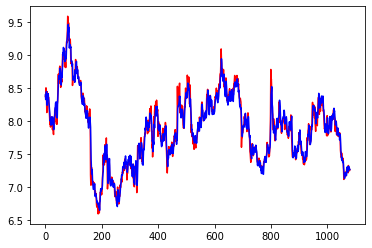

In [10]:
# 这是 train 的预测图形
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()
# print(train_real_value_list)

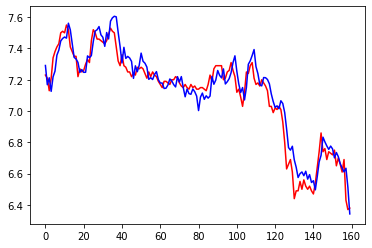

In [11]:
# 这是 vali的预测图形
plt.plot(valid_real_value_list, 'r-')
plt.plot(valid_pred_value_list, 'b-')
plt.show()

In [12]:
# 用模型预测数据
# 考虑到时序因素，这里的时候误差很大。
model.eval()
test_loss = 0
h0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, TEST_BATCH_SIZE, HIDDEN_SIZE).float().to(device)

for step in range(test_x.shape[0]):
    pred,_,_ = model(test_x[step], h0, c0)
    
    loss = loss_func(pred[:,-1,-1], test_y[step][:,-1,-1])               # Compare the all sequences' last element in one batch
    
    if test_x.shape[0] > 1:
        actual_line.append(test_y[step][-1,-1].item())
        pred_line.append(pred[-1,-1].item())
    elif test_x.shape[0] == 1:
        actual_line = test_y[step].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
        pred_line   = pred[:,-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
        
# print("Test Loss : {:.3f}".format(loss.data))
print("Prediction: {:.2f}".format(float(pred[-1,-1].data)))
print("Actual:     {:.2f}".format(float(test_y[step][-1,-1].data)))


# plt.plot(test_y[step,:,-1,-1].cpu().detach().flatten().numpy(), 'r--')
# plt.plot(pred[:,-1].cpu().detach().flatten().numpy(), 'b-')
# plt.show()
# print(test_y[step,:,-1,-1].cpu().detach().flatten().numpy())
print(pred[-1,].cpu().detach().flatten().numpy())

Prediction: 6.40
Actual:     0.00
[0.10882775 0.2747766  0.5129305  0.72531384 0.95237416 1.2213233
 1.5255095  1.869745   2.2159145  2.5084145  2.8127854  3.143861
 3.4687293  3.7918146  4.1461496  4.4371285  4.709119   4.9407544
 5.190094   5.4740148  5.6992216  5.8441753  6.0237436  6.2256236
 6.401515  ]


In [13]:
# 把rolling_data再分割为 train / test 就再预测
# 既然 预测值 和时序相关性很高，可以考虑太早的零星数据对于test影响不大，可以删掉
print(rolling_data.shape)
print(TRAIN_BATCH_SIZE)
print(((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE)
rolling_data = rolling_data[-((rolling_data.shape[0]-1)//TRAIN_BATCH_SIZE)*TRAIN_BATCH_SIZE-1:,]
print(rolling_data.shape)

train = rolling_data[:-1].reshape(-1, TRAIN_BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                    # 把数据转成 tain_batch_count x TRAIN_BATCH_SIZE x seq_len x in_dim 格式
test  = rolling_data[-1:].reshape(1, 1, SEQ_LENGTH, X_DIM+Y_DIM*Y_SEQ_LEN)                     # 把数据转成 test_batch_count x TEST_BATCH_SIZE x seq_len x in_dim 格式

train = torch.tensor(train).to(device)
test  = torch.tensor(test).to(device)

train_x, train_y = train[:,:,:,Y_SEQ_LEN:], train[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_SEQ_LEN:],  test[:,:,-1:,0:Y_SEQ_LEN]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(test_y)

(1260, 25, 136)
40
1240
(1241, 25, 136)
torch.Size([31, 40, 25, 135]) torch.Size([31, 40, 1, 1])
torch.Size([1, 1, 25, 135]) torch.Size([1, 1, 1, 1])
tensor([[[[0.]]]], device='cuda:0', dtype=torch.float64)


In [14]:
# # 再重新生成模型再 train 模型
# model = LSTMModel(input_size=X_DIM, hidden_dim_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).float().to(device)
# LR = 1e-5
# # loss_func = nn.MSELoss(reduction="mean")
# loss_func = RMSELoss
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1, last_epoch=-1)
# model.train()

# h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
# c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


# for epoch in range(epoches):
#     batch_loss = []
#     train_epoch_loss = 0
#     train_pred_value_list = []
#     train_real_value_list = []
#     train_batch_list = list(range(0,train_batch_count))
#     # random.shuffle(train_batch_list)
#     for step in range(0, train_x.shape[0]):
#         train_pred, hn, cn = model(train_x[step], h0, c0)
#         # h0, c0 = hn.detach(), cn.detach()
#         loss = loss_func(train_pred[:,-1,-1], train_y[step][:,-1,-1])                # Compare the all sequences' last element in one batch
#         train_pred_value_list.extend(list(train_pred[:,-1,-1].cpu().detach().flatten().numpy() ))
#         train_real_value_list.extend(list(train_y[step,:,-1,-1].cpu().detach().flatten().numpy() ))
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
#         optimizer.step()
#         batch_loss.append(loss.cpu().data.numpy())
#     if ((epoch+1) %10) == 0:
#         print("{} of {} epoch   train_loss: {:.6f}".format(epoch, epoches, np.mean(batch_loss)))
#     train_epoch_loss = np.mean(batch_loss)
    
# plt.plot(train_real_value_list, 'r-')
# plt.plot(train_pred_value_list, 'b-')
# plt.show()    

9 of 2000 epoch 	 train_loss: 0.102 	 train_MAPE: 0.99% 	 train_r2: 0.665
19 of 2000 epoch 	 train_loss: 0.101 	 train_MAPE: 0.98% 	 train_r2: 0.681
29 of 2000 epoch 	 train_loss: 0.102 	 train_MAPE: 1.01% 	 train_r2: 0.671
39 of 2000 epoch 	 train_loss: 0.102 	 train_MAPE: 0.99% 	 train_r2: 0.678
49 of 2000 epoch 	 train_loss: 0.100 	 train_MAPE: 0.97% 	 train_r2: 0.702
59 of 2000 epoch 	 train_loss: 0.099 	 train_MAPE: 0.97% 	 train_r2: 0.706
69 of 2000 epoch 	 train_loss: 0.100 	 train_MAPE: 0.98% 	 train_r2: 0.700
79 of 2000 epoch 	 train_loss: 0.098 	 train_MAPE: 0.95% 	 train_r2: 0.718
89 of 2000 epoch 	 train_loss: 0.099 	 train_MAPE: 0.95% 	 train_r2: 0.715
99 of 2000 epoch 	 train_loss: 0.098 	 train_MAPE: 0.95% 	 train_r2: 0.714
109 of 2000 epoch 	 train_loss: 0.097 	 train_MAPE: 0.94% 	 train_r2: 0.730
119 of 2000 epoch 	 train_loss: 0.098 	 train_MAPE: 0.94% 	 train_r2: 0.718
129 of 2000 epoch 	 train_loss: 0.097 	 train_MAPE: 0.94% 	 train_r2: 0.730
139 of 2000 epoch 	 tra

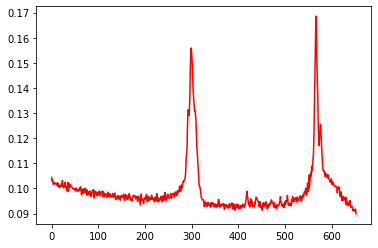

min train loss: 0.090


In [15]:
def ACC(y_hat, y_real):
    y_real = np.array(y_real) + 1
    y_hat = np.array(y_hat) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((y_real - y_hat) / y_real)))
    return percentage * 100

# 定义 RMSE 损失函数。因为torch没有。
def RMSE(y_hat, y):
    return torch.sqrt(torch.mean((y_hat-y)**2))


# 定义 MAPE 计算函数。平均绝对百分比误差：不受量纲影响。但y接近0时受极端值影响。为（0%）表示完美模型，MAPE 大于 （100%）则表示劣质模型。
def MAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y)+1e-7)
    return torch.mean(absolute_percent_error)

# 定义了 R2 的计算函数。决定系数：反映因变量的全部变异能通过回归关系被自变量解释的比例。
# R2<=1，R2为1时说明预测模型不犯任何错误；R2为0时说明预测模型等于基准模型；R2小于0说明预测模型不如基准模型，可能数据不存在任何线性关系。
def R2(y_hat, y):
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_hat) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

# 定义 SMAPE 计算函数。修复了原始MAPE的缺点-它同时具有下限（0％）和上限（200％)
def SMAPE(y_hat, y):
    absolute_percent_error = (torch.abs(y_hat-y)+1e-7)/(torch.abs(y_hat)+torch.abs(y)+1e-7)
    return 2.0 * torch.mean(absolute_percent_error)



# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epochs = 2000
train_epoch_loss = 0
train_epoch_loss_list = []
train_epoch_acc_list = []
valid_epoch_loss = 0
valid_epoch_loss_list = []
valid_epoch_acc_list = []

train_batch_count = train_x.shape[0]
valid_batch_count = valid_x.shape[0]

h0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, TRAIN_BATCH_SIZE, HIDDEN_SIZE).float().to(device)


for epoch in range(epochs):
    batch_loss = []
    batch_mape = []
    batch_r2   = []
    train_epoch_loss = 0
    train_epoch_mape = 0
    train_epoch_r2 = 0
    train_pred_value_list = []
    train_real_value_list = []
    train_batch_list = list(range(0, train_batch_count))
    # random.shuffle(train_batch_list)
    for step in train_batch_list:
        train_pred, hn, cn = model(train_x[step], h0, c0)                                                    # pred: [batch_size, seq_len, out_dim]  但被修改成了 [batch_size, 1, out_dim]
        loss = loss_func(train_pred[:, -1, -1], train_y[step][:, -1, -1])                                    # 取batch里每个sequence最后一个预测输出来和实际
        train_pred_value_list.extend(list(train_pred[:, -1, -1].cpu().detach().flatten().numpy() ))
        train_real_value_list.extend(list(train_y[step][:, -1, -1].cpu().detach().flatten().numpy() ))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        batch_loss.append(loss.cpu().data.numpy())
        batch_mape.append(MAPE(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
        batch_r2.append(R2(train_pred[:, -1, -1], train_y[step][:, -1, -1]).item())
    # print(batch_mape)
    train_epoch_loss = np.mean(batch_loss)
    train_epoch_mape = np.mean(batch_mape)
    train_epoch_r2 = np.mean(batch_r2)

    train_epoch_loss_list.append(train_epoch_loss)

    if ((epoch+1) % 10) == 0:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2))
        
    if train_epoch_loss < 0.09:
        print("{} of {} epoch \t train_loss: {:.3f} \t train_MAPE: {:.2%} \t train_r2: {:.3f}".format(epoch, epochs, train_epoch_loss, train_epoch_mape, train_epoch_r2))
        print("****************************************** STOP TRAIN  ****************************************")
        break

plt.plot(train_epoch_loss_list, 'r-')
plt.show()
print("min train loss: {:.3f}".format(min(train_epoch_loss_list)))

In [16]:
print(train_pred.shape)
print(train_y.shape)

print(train_y[-1,-1])
print(train_pred[-1,-1])

torch.Size([40, 25, 1])
torch.Size([31, 40, 1, 1])
tensor([[6.4200]], device='cuda:0', dtype=torch.float64)
tensor([6.4274], device='cuda:0', grad_fn=<SelectBackward0>)


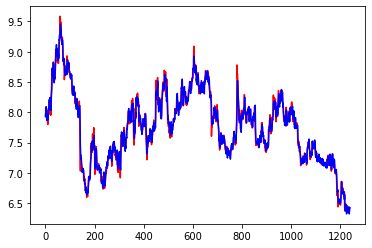

In [17]:
plt.plot(train_real_value_list, 'r-')
plt.plot(train_pred_value_list, 'b-')
plt.show()

In [18]:
# print(train_x.shape)
# print(test_x.shape)
# print(train_real_value_list[-1])
print(train_pred_value_list[-1])

6.4273705


In [19]:
model.eval()

h0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).float().to(device)
c0 = torch.zeros(NUM_LAYERS, test_x.shape[1], HIDDEN_SIZE).float().to(device)

pred, hn, cn = model(test_x[-1], h0, c0)

# print(test_y.shape)
# print(pred.shape)
# print(test_y)
print(pred[:,-1,:].item())

6.462803840637207
